In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [28]:
from nba_api.stats.endpoints import playercareerstats
import time
from nba_api.stats.endpoints import leaguegamelog
import pandas as pd

def get_season_schedule(season):
    
    call_season = leaguegamelog.LeagueGameLog(season=season)
    season = pd.concat(call_season.get_data_frames())
    
    season['home_game'] = season['MATCHUP'].apply(lambda x : False if (x.find('@') != -1) else True)
    
    return season
from nba_api.stats.endpoints import playercareerstats
from nba_api.stats.endpoints import boxscoretraditionalv2
import time

def player_data_for_game(game_id, team_ids):
    
    # get boxscore for game
    call_boxscore = boxscoretraditionalv2.BoxScoreTraditionalV2(game_id=game_id)
    boxscore = pd.concat(call_boxscore.get_data_frames())
    
    # get players listed for this game
    players_game = boxscore['PLAYER_ID'].drop_duplicates().dropna()
    
    # init list of player data
    list_player = list()
    
    # loop over theses players to get their career stats
    for player in players_game:
        
        print(player)
        call_player = playercareerstats.PlayerCareerStats(player_id=str(int(player)), per_mode36="PerGame")
        
        # clean the returned
        tmp = carrer_stats_clean(pd.concat(call_player.get_data_frames()))
        
        # append to list
        list_player.append(tmp)
        
        # sleep to don't overstress - set as parameter in code later, to fine tune wait times more easily
        time.sleep(1)
        
    return pd.concat(list_player), boxscore

from nba_api.stats.endpoints import boxscoretraditionalv2
import time

def boxscores_for_team(team_id, season_obj):
    
    # get the ids of all the games our team has played
    team_game_ids = season_obj[season_obj['TEAM_ID'] == team_id]
    
    # subset to those games
    bool_matchups = season_obj['GAME_ID'].isin(team_game_ids['GAME_ID'])
    team_season = season_obj[bool_matchups]
    
    # get the unique game ids for the teams season
    game_ids = team_season['GAME_ID'].unique()
    
    # init the boxscore list
    boxscore = list()
    
    # loop over those games
    for game in game_ids:
        
        # get boxscore for game
        call_boxscore = boxscoretraditionalv2.BoxScoreTraditionalV2(game_id=game)
        boxscore.append(pd.concat(call_boxscore.get_data_frames()))
        
        # sleep and print
        time.sleep(0.5)
        print(game)
    
    # create full dataframe
    team_boxscores = pd.concat(boxscore)
    
    # subset, such that only the starting fives are left (simplification)
    bool_startingfive = ((team_boxscores['START_POSITION'] == "G")|(team_boxscores['START_POSITION'] == "F")|(team_boxscores['START_POSITION'] == "C"))
    boxscore_startingfive = team_boxscores[bool_startingfive]
    
    return team_season, boxscore_startingfive

from nba_api.stats.static import teams
from nba_api.stats.endpoints import playercareerstats
def player_ability(team_boxscores, team_id):
    
    starting_fives = team_boxscores[team_boxscores['TEAM_ID'] == team_id]['PLAYER_ID'].unique()
    list_player = list()

    for starter in starting_fives:
        call_player = playercareerstats.PlayerCareerStats(player_id=str(int(starter)), per_mode36="PerGame")

        # clean the returned
        df = pd.concat(call_player.get_data_frames())
    
        # get array of all team ids
        nba_teams = pd.DataFrame(teams.get_teams())
        team_ids = np.unique(nba_teams['id'])

        # columns to drop
        drop_list = ["Team_ID", "ORGANIZATION_ID", "SCHOOL_NAME", "RANK_PG_MIN", "RANK_PG_FGM", "RANK_PG_FGA",
                 "RANK_FG_PCT", "RANK_PG_FG3M", "RANK_PG_FG3A", "RANK_FG3_PCT", "RANK_PG_FTM", "RANK_PG_FTA",
                "RANK_FT_PCT", "RANK_PG_OREB", "RANK_PG_DREB", "RANK_PG_REB", "RANK_PG_AST", "RANK_PG_STL",
                "RANK_PG_BLK", "RANK_PG_TOV", "RANK_PG_PTS", "RANK_PG_EFF"]

        # ids of the nba teams - removes all-star appearances
        bool_nbateam = df['TEAM_ID'].isin(team_ids)

        # drop cols
        df = df.loc[:, ['PLAYER_ID', 'SEASON_ID', 'TEAM_ID', 'PLAYER_AGE', 'GP', 
                        'GS', 'MIN', 'FG_PCT', 'FGA', 'FG3_PCT', 'FG3A', 'FT_PCT', 'FTA', 'OREB', 'DREB', 'REB',
                       'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS']]

        # remove all "other teams" e.g. all-star and totals
        df = df[bool_nbateam]

        # drop na's
        df = df.dropna()

        # keep first observations - what exactly are those?
        tmp = df[~df.index.duplicated(keep='first')]

        # append to list
        list_player.append(tmp)

        time.sleep(0.5)
        print(starter)

    # return dataframe
    return pd.concat(list_player)

def aggregate_stats(player_stats):
    
    # switch out creation for later procedure
    aggregate_player = player_stats.groupby("PLAYER_ID").mean()['MIN']
    
    # return in good shape and rename
    tmp = pd.DataFrame(aggregate_player)
    tmp = tmp.reset_index()
    
    return tmp.rename(columns={"MIN": "ability_MIN"})
from nba_api.stats.static import teams
from nba_api.stats.endpoints import playercareerstats
import numpy as np
import pandas as pd

def get_carrer_stats_clean(player_id):
    
    # api call
    call_player = playercareerstats.PlayerCareerStats(player_id=player_id, per_mode36="PerGame")
    df = pd.concat(call_player.get_data_frames())
    
    # get array of all team ids
    nba_teams = pd.DataFrame(teams.get_teams())
    team_ids = np.unique(nba_teams['id'])
    
    # columns to drop
    drop_list = ["Team_ID", "ORGANIZATION_ID", "SCHOOL_NAME", "RANK_PG_MIN", "RANK_PG_FGM", "RANK_PG_FGA",
             "RANK_FG_PCT", "RANK_PG_FG3M", "RANK_PG_FG3A", "RANK_FG3_PCT", "RANK_PG_FTM", "RANK_PG_FTA",
            "RANK_FT_PCT", "RANK_PG_OREB", "RANK_PG_DREB", "RANK_PG_REB", "RANK_PG_AST", "RANK_PG_STL",
            "RANK_PG_BLK", "RANK_PG_TOV", "RANK_PG_PTS", "RANK_PG_EFF"]
    
    # ids of the nba teams - removes all-star appearances
    bool_nbateam = df['TEAM_ID'].isin(team_ids)
    
    # drop cols
    df = df.loc[:, ['PLAYER_ID', 'SEASON_ID', 'TEAM_ID', 'PLAYER_AGE', 'GP', 
                    'GS', 'MIN', 'FG_PCT', 'FGA', 'FG3_PCT', 'FG3A', 'FT_PCT', 'FTA', 'OREB', 'DREB', 'REB',
                   'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS']]
    
    # remove all "other teams" e.g. all-star and totals
    df = df[bool_nbateam]
    
    # drop na's
    df = df.dropna()
    
    # keep first observations - what exactly are those?
    df = df[~df.index.duplicated(keep='first')]

    return df

In [29]:
# season parameter
seasons_subset = ['2020-21', '2019-20', '2018-19', '2017-18', '2016-17']
seasons = [22021, 22020, 22019, 22018, 22017, 22016]

# load scores edit season id
rapm = pd.read_csv("FourFactorsRAPM.csv", delimiter=",", skiprows=1)
coef = pd.read_csv("./data/season_prediction/player_season_scores.csv")
coef = coef[['PLAYER_ID', 'SEASON_ID', 'coef']].rename(columns={'PLAYER_ID':'playerId','SEASON_ID':'season'})
scores = pd.merge(rapm, coef, on=['playerId', 'season'], how='left')
scores = scores.reset_index().drop(['index'], axis=1)
scores = scores[scores['season'].isin(seasons_subset)]
scores['playerId'] = scores['playerId'].astype(str)
scores = scores.sort_values('season')

# rename for merging
scores.loc[scores['season'] == "2020-21",'season'] = 22020
scores.loc[scores['season'] == "2019-20",'season'] = 22019
scores.loc[scores['season'] == "2018-19",'season'] = 22018
scores.loc[scores['season'] == "2017-18",'season'] = 22017
scores.loc[scores['season'] == "2016-17",'season'] = 22016

In [30]:
# function to arrive at performance tomorrow
def geo_weight(n):
    weight = np.arange(start=1, stop=n+1) / np.arange(start=1, stop=n+1).sum()
    return np.flip(weight)

def geo_mean(x):
    return np.sum(x * geo_weight(x.shape[0]))

In [93]:
# season parameter
seasons_subset = ['2020-21', '2019-20', '2018-19', '2017-18', '2016-17']
seasons = [22021, 22020, 22019, 22018, 22017, 22016]

# load scores edit season id
rapm = pd.read_csv("FourFactorsRAPM.csv", delimiter=",", skiprows=1)
coef = pd.read_csv("./data/season_prediction/player_season_scores.csv")
coef = coef[['PLAYER_ID', 'SEASON_ID', 'coef']].rename(columns={'PLAYER_ID':'playerId','SEASON_ID':'season'})
scores = pd.merge(rapm, coef, on=['playerId', 'season'], how='left')
scores = scores.reset_index().drop(['index'], axis=1)
scores = scores[scores['season'].isin(seasons_subset)]
scores['playerId'] = scores['playerId'].astype(str)
scores = scores.sort_values('season')

# rename for merging
scores.loc[scores['season'] == "2020-21",'season'] = 22020
scores.loc[scores['season'] == "2019-20",'season'] = 22019
scores.loc[scores['season'] == "2018-19",'season'] = 22018
scores.loc[scores['season'] == "2017-18",'season'] = 22017
scores.loc[scores['season'] == "2016-17",'season'] = 22016

In [31]:
scores_next = scores.sort_values('season', ascending=False).groupby('playerId')['RAPM'].apply(lambda x: geo_mean(x)).reset_index()
scores_next['season'] = 22021
scores = pd.concat([scores, scores_next])

In [24]:
scores['season'].unique()

array([22016, 22017, 22018, 22019, 22020, 22021], dtype=object)

In [32]:
df_schedule_load = pd.read_csv("./data/season_prediction/schedule.csv", dtype={'GAME_ID':str})
df_boxscores_load = pd.read_csv("./data/season_prediction/boxscores.csv", dtype={'GAME_ID':str})

current_boxscores = pd.read_csv("./data/season_prediction/boxscores_current.csv", dtype={'GAME_ID':str})
current_schedule =  pd.read_csv("./data/season_prediction/schedule_current.csv", dtype={'GAME_ID':str})

# concatenate
df_schedule = pd.concat([df_schedule_load, current_schedule])
df_boxscores = pd.concat([df_boxscores_load, current_boxscores])

In [26]:
# load the last full seasons and this season, so far it took place
df_schedule_load = pd.read_csv("./data/season_prediction/schedule.csv", dtype={'GAME_ID':str})
df_boxscores_load = pd.read_csv("./data/season_prediction/boxscores.csv", dtype={'GAME_ID':str})

current_boxscores = pd.read_csv("./data/season_prediction/boxscores_current.csv", dtype={'GAME_ID':str})
current_schedule =  pd.read_csv("./data/season_prediction/schedule_current.csv", dtype={'GAME_ID':str})

current_schedule = df_schedule_load[df_schedule_load['SEASON_ID'] == 22020]
games_season = current_schedule['GAME_ID'].unique()
current_boxscores = df_boxscores_load[df_boxscores_load['GAME_ID'].isin(games_season)]
current_schedule['SEASON_ID'] = 22021

fakeid = 'fake_id_'
current_boxscores['GAME_ID'] = current_boxscores['GAME_ID'].apply(lambda x: fakeid + x)
current_schedule['GAME_ID'] = current_schedule.loc[current_schedule['SEASON_ID'] == 22021, 'GAME_ID'].apply(lambda x: fakeid + x)

# concatenate
df_schedule = pd.concat([df_schedule_load, current_schedule])
df_boxscores = pd.concat([df_boxscores_load, current_boxscores])

In [33]:
# select seasons
df_schedule = df_schedule[df_schedule['SEASON_ID'].isin(seasons)]

games = df_schedule['GAME_ID'].unique()
df_boxscores = df_boxscores[df_boxscores['GAME_ID'].isin(games)]

# merge schedule and boxscores
df = pd.merge(df_schedule, df_boxscores, how='left', on=["GAME_ID", 'TEAM_ID'], suffixes=("_team", "_player"))
df['home_game'] = df['MATCHUP'].apply(lambda x: x.find('@') == -1)

df['PLAYER_ID'] = df['PLAYER_ID'].astype(float)
scores['playerId'] = scores['playerId'].astype(float)

# merge scores and df
df = pd.merge(df, scores, how='left', left_on=['PLAYER_ID', 'SEASON_ID'], right_on=['playerId', 'season'])

In [34]:
import itertools

def preprocess_season_data(schedule, boxscores, scores, seasons: list):
    """ create preprocessed dataframe from schedule and boxscores
    """
    # init variables
    df_schedule = schedule
    df_boxscores = boxscores
    
    # select seasons
    df_schedule = df_schedule[df_schedule['SEASON_ID'].isin(seasons)]

    games = df_schedule['GAME_ID'].unique()
    df_boxscores = df_boxscores[df_boxscores['GAME_ID'].isin(games)]

    # merge schedule and boxscores
    df = pd.merge(df_schedule, df_boxscores, on=["GAME_ID", 'TEAM_ID'], suffixes=("_team", "_player"))
    df['home_game'] = df['MATCHUP'].apply(lambda x: x.find('@') == -1)
    
    df['PLAYER_ID'] = df['PLAYER_ID'].astype(float)
    scores['playerId'] = scores['playerId'].astype(float)
    
    # merge scores and df
    df = pd.merge(df, scores, how='left', left_on=['PLAYER_ID', 'SEASON_ID'], right_on=['playerId', 'season'])

    # create sixth man
    sixth_man = pd.DataFrame(df[df['START_POSITION'].isna()].groupby(['TEAM_ID', 'GAME_ID'])['RAPM'].aggregate('mean')).reset_index().drop_duplicates()
    sixth_man['START_POSITION'] = "SIXTH_MAN"
    df_sixth = pd.merge(sixth_man, df[['GAME_ID', 'TEAM_ID', 'home_game']], how='right', on=['GAME_ID', 'TEAM_ID'])
    df_sixth = df_sixth.drop_duplicates()

    # calculate bench depth
    df['BENCH'] = df['START_POSITION'].isna()
    bench_depth = pd.DataFrame(df.groupby(['GAME_ID', 'TEAM_ID'])['BENCH'].sum()).reset_index().drop_duplicates()
    bench_depth = bench_depth.rename(columns={'BENCH':'BENCH_DEPTH'})
    df = pd.merge(df, bench_depth, how='left')

    # mark bench depth
    df.loc[df['home_game'], 'BENCH_DEPTH_TEAM'] = 'BENCH_DEPTH_HOME'
    df.loc[~df['home_game'], 'BENCH_DEPTH_TEAM'] = 'BENCH_DEPTH_AWAY'
    
    df['is_home_game'] = df['home_game']

    # append to dataframe
    df = df.append(df_sixth)

    # filter for Starters only
    df = df[~df['START_POSITION'].isna()]
    df2 = df

    # create counts
    half = int(df.shape[0] / 2)
    repetitions_half = int(half / 6)

    # first step for role player variable
    sixth_home = ['SIXTH_HOME_1'] * repetitions_half
    guard_home = ['GUARD_HOME_1', 'GUARD_HOME_2'] * repetitions_half
    forward_home = ['FORWARD_HOME_1', 'FORWARD_HOME_2'] * repetitions_half
    center_home = ['CENTER_HOME_1'] * repetitions_half

    sixth_away = ['SIXTH_AWAY_1'] * repetitions_half
    guard_away = ['GUARD_AWAY_1', 'GUARD_AWAY_2'] * repetitions_half
    forward_away = ['FORWARD_AWAY_1', 'FORWARD_AWAY_2'] * repetitions_half
    center_away = ['CENTER_AWAY_1'] * repetitions_half

    # create player role
    player_role = list(itertools.chain(sixth_home, guard_home, forward_home, center_home, 
                                       sixth_away, guard_away, forward_away, center_away))

    # sort values and insert the player role
    df = df.sort_values(['home_game', 'START_POSITION'], ascending=False)
    df['PLAYER_COURT_ROLE'] = np.asarray(player_role)
    
    # quick and dirty nan fill
    df = df.sort_values('GAME_ID')
    df['SEASON_ID'] = df['SEASON_ID'].ffill()
    df['SEASON_ID'] = df['SEASON_ID'].bfill()
    
    df = df.sort_values(['SEASON_ID', 'GAME_ID'])
    df['PLUS_MINUS'] = df.groupby('GAME_ID')['PLUS_MINUS'].transform(lambda x: x.ffill())
    
    return df

In [35]:
def trade_player_function(player_in, player_out, df, scores):
    """
    
    :param df: dataframe, merged schedule and boxscores - already existing RAPM column
    :param scores: dataframe, containt mapping from playerid and seasonid to performance score
    """
    
    # player in, player out id
    #player_in = 2544
    #player_out = 203939

    # get name
    player_in_name = df[df['PLAYER_ID'] == player_in]['PLAYER_NAME'].values[0]
    player_out_name = df[df['PLAYER_ID'] == player_out]['PLAYER_NAME'].values[0]
    
    # get team of "out" player i.e. our team
    out_team_id = df[df['PLAYER_ID'] == player_out]['TEAM_ID'].unique()[-1]
    in_team_id = df[df['PLAYER_ID'] == player_in]['TEAM_ID'].unique()[-1]

    # copy the dataframe
    df2 = df.copy()

    # get performance scores - be careful with the respective season!
    recent_rapm_in = scores[scores['playerId'] == player_in].sort_values('season', ascending=False)['RAPM'].values[0]
    recent_rapm_out = scores[scores['playerId'] == player_out].sort_values('season', ascending=False)['RAPM'].values[0]

    # sub in the player_in
    df2['PLAYER_OUT_ID'] = df2['PLAYER_ID']
    df2.loc[df['PLAYER_ID'] == player_out, 'PLAYER_ID'] = player_in
    df2.loc[df['PLAYER_ID'] == player_out, 'RAPM'] = recent_rapm_in
    df2.loc[df['PLAYER_ID'] == player_out, 'PLAYER_NAME'] = player_in_name

    # transfer player_out to player_in's former team
    df2.loc[df2['PLAYER_OUT_ID'] == player_in, 'PLAYER_ID'] = player_out
    df2.loc[df2['PLAYER_OUT_ID'] == player_in, 'RAPM'] = recent_rapm_out
    df2.loc[df2['PLAYER_OUT_ID'] == player_in, 'PLAYER_NAME'] = player_out_name
    
    # fill in missing game scores with respect to game
    #df2 = df2.groupby('GAME_ID')['PLUS_MINUS'].transform(lambda x: x.bfill())

    return df2, out_team_id, in_team_id

In [36]:
def get_model_data(df):
    """
    """
    df = df[['MATCHUP', 'home_game', 'SEASON_ID', 'TEAM_ID', 'GAME_ID', 'PLAYER_ID', 'PLAYER_NAME', 'START_POSITION', 'TEAM_ABBREVIATION_team', 'RAPM','PLUS_MINUS','PLAYER_COURT_ROLE', 'BENCH_DEPTH_TEAM', 'BENCH_DEPTH']]
    df['playerName'] = df['PLAYER_NAME']
    
    # subset dataframes
    df_sub = df[['PLUS_MINUS', 'home_game', 'TEAM_ID','TEAM_ABBREVIATION_team','GAME_ID', 'SEASON_ID', 'PLAYER_ID', 'playerName', 'PLAYER_COURT_ROLE', 'RAPM', 'BENCH_DEPTH_TEAM', 'BENCH_DEPTH']]
    df_reg = df_sub[['PLUS_MINUS', 'home_game', 'TEAM_ID','GAME_ID', 'SEASON_ID', 'PLAYER_ID', 'PLAYER_COURT_ROLE', 'RAPM', 'BENCH_DEPTH_TEAM', 'BENCH_DEPTH']]

    sub_bench = df_reg[['GAME_ID', 'BENCH_DEPTH_TEAM', 'BENCH_DEPTH']].drop_duplicates()
    sub_bench = sub_bench.pivot('GAME_ID', 'BENCH_DEPTH_TEAM', 'BENCH_DEPTH').reset_index()

    # create df model frame
    df_reg_scores = df_reg[['GAME_ID', 'PLUS_MINUS', 'home_game']]
    wide = df_reg.pivot(['GAME_ID', 'SEASON_ID'], 'PLAYER_COURT_ROLE', 'RAPM').reset_index()
    df_model = pd.merge(wide, df_reg_scores)
    df_model = pd.merge(df_model, sub_bench, how='left', on='GAME_ID')

    #df_interpretation = df_model[['GAME_ID', 'SEASON_ID', 'home_game', 'GUARD_HOME_1', 'GUARD_HOME_2', 'FORWARD_HOME_1', 'FORWARD_HOME_2', 'CENTER_HOME_1', 'SIXTH_HOME_1', 'BENCH_DEPTH_HOME', 'GUARD_AWAY_1', 'GUARD_AWAY_2', 'FORWARD_AWAY_1', 'FORWARD_AWAY_2', 'CENTER_AWAY_1', 'SIXTH_AWAY_1', 'BENCH_DEPTH_AWAY', 'PLUS_MINUS']]
    df_model = df_model[['SEASON_ID','GAME_ID', 'home_game', 'GUARD_HOME_1', 'GUARD_HOME_2', 'FORWARD_HOME_1', 'FORWARD_HOME_2', 'CENTER_HOME_1', 'SIXTH_HOME_1', 'BENCH_DEPTH_HOME', 'GUARD_AWAY_1', 'GUARD_AWAY_2', 'FORWARD_AWAY_1', 'FORWARD_AWAY_2', 'CENTER_AWAY_1', 'SIXTH_AWAY_1', 'BENCH_DEPTH_AWAY', 'PLUS_MINUS']]

    # drop duplicates and keep only observations from HT perspective
    df_model = df_model.drop_duplicates()
    #df_model = df_model.dropna()
    df_model = df_model[df_model['home_game']]
    
    #df_interpretation = df_interpretation.drop_duplicates()
    #df_interpretation = df_interpretation.dropna()
    #df_interpretation = df_interpretation[df_interpretation['home_game']]

    # merge back to schedule for interpretation
    #df_interpretation = pd.merge(df_schedule, df_interpretation, on="GAME_ID", how='right')
    #df_interpretation = df_interpretation[df_interpretation['home_game']]
    #df_interpretation = df_interpretation.drop_duplicates()
    
    # get home and away team
    #df_interpretation['HOME_TEAM_ABB'] = df_interpretation['MATCHUP'].apply(lambda x: x[0:3])
    #df_interpretation['AWAY_TEAM_ABB'] = df_interpretation['MATCHUP'].apply(lambda x: x[-3:])
    
    #df_interpretation = df_interpretation[~df_interpretation['PLUS_MINUS_y'].isna()]
    
    pos_features = ['GUARD_HOME_1', 'GUARD_HOME_2', 'FORWARD_HOME_1', 'FORWARD_HOME_2', 'CENTER_HOME_1', 'SIXTH_HOME_1', 'BENCH_DEPTH_HOME', 'GUARD_AWAY_1', 'GUARD_AWAY_2', 'FORWARD_AWAY_1', 'FORWARD_AWAY_2', 'CENTER_AWAY_1', 'SIXTH_AWAY_1']
    pos2_features = list()
    
    for pos in pos_features:
        pos2 = pos + "_2"
        pos2_features.append(pos2)
        df_model[pos2] = df_model[pos] * np.abs(df_model[pos]) # preserve sign
    
    return df_model.sort_values(['SEASON_ID', 'GAME_ID'])

In [37]:
def get_train_season_games(df, last_train_season):
    """ helper function to get n_games for subset
    
    :param last_train_season: enter in 22016 format
    """
    train_seasons = np.arange(22016, last_train_season + 1)
    n_games = df[df['SEASON_ID'].isin(train_seasons)].shape[0]
    
    return int(n_games / 12)

In [63]:
def get_train_test_set(df_model, last_train_season):
    """
    """
    
    df_model = df_model.groupby(['SEASON_ID', 'GAME_ID', 'home_game']).first().reset_index()
    
    train_seasons = np.arange(22016, last_train_season + 1)
    
    df_model = df_model.drop_duplicates()
    #df_interpretation = df_interpretation.drop_duplicates()
    
    df_model_train = df_model[df_model['SEASON_ID'].isin(train_seasons)]
    df_model_test = df_model[~df_model['SEASON_ID'].isin(train_seasons)]
    
    #df_int_train = df_interpretation[df_interpretation['SEASON_ID_x'].isin(train_seasons)]
    #df_int_test = df_interpretation[~df_interpretation['SEASON_ID_x'].isin(train_seasons)]
    
    # seperate into labels and features
    
    features_names = ['GUARD_HOME_1', 
                      'GUARD_HOME_2', 
                      'FORWARD_HOME_1', 
                      'FORWARD_HOME_2', 
                      'CENTER_HOME_1', 
                      'SIXTH_HOME_1', 
                      'GUARD_AWAY_1', 
                      'GUARD_AWAY_2', 
                      'FORWARD_AWAY_1', 
                      'FORWARD_AWAY_2', 
                      'CENTER_AWAY_1', 
                      'SIXTH_AWAY_1', 
                      'GUARD_HOME_1_2',
                      'GUARD_HOME_2_2',
                      'FORWARD_HOME_1_2',
                      'FORWARD_HOME_2_2',
                      'CENTER_HOME_1_2',
                      'SIXTH_HOME_1_2',
                      'GUARD_AWAY_1_2',
                      'GUARD_AWAY_2_2',
                      'FORWARD_AWAY_1_2',
                      'FORWARD_AWAY_2_2',
                      'CENTER_AWAY_1_2',
                      'SIXTH_AWAY_1_2']
    
    X_train = df_model_train[features_names].to_numpy()
    y_train = df_model_train['PLUS_MINUS'].to_numpy()
    
    X_test = df_model_test[features_names].to_numpy()
    y_test = df_model_test['PLUS_MINUS'].to_numpy()

    # get bool for na rows
    na_rows_train = (~np.isnan(X_train).any(axis=1)) & (~np.isnan(y_train))
    na_rows_test = (~np.isnan(X_test).any(axis=1)) & (~np.isnan(y_test))
    
    # remove na
    X_train, X_test = X_train[na_rows_train], X_test[na_rows_test]
    y_train, y_test = y_train[na_rows_train], y_test[na_rows_test]
    df_model_train, df_model_test = df_model_train[na_rows_train], df_model_test[na_rows_test]
    #df_int_train, df_int_test = df_int_train[na_rows_train], df_int_test[na_rows_test]
    
    
    return X_train, y_train, X_test, y_test, df_model_train, df_model_test

In [89]:
# seperate out 2020
df_sched_full = df_schedule[df_schedule['SEASON_ID'] == 22020]
season_games = df_sched_full['GAME_ID'].unique()
df_boxs_full = df_boxscores[df_boxscores['GAME_ID'].isin(season_games)]

# forward
df_sched_full['SEASON_ID'] = 22021
df_sched_full['GAME_ID'] = df_sched_full['GAME_ID'].apply(lambda x: 'fake_id' + x)
df_boxs_full['GAME_ID'] = df_boxs_full['GAME_ID'].apply(lambda x: 'fake_id' + x)

# drop 2021
season_games = df_schedule[df_schedule['SEASON_ID'] == 22021]['GAME_ID'].unique()
df_schedule = df_schedule[df_schedule['SEASON_ID'] != 22021]
df_boxscores = df_boxscores[~df_boxscores['GAME_ID'].isin(season_games)]

# add to 2020
df_schedule = pd.concat([df_schedule, df_sched_full])
df_boxscores = pd.concat([df_boxscores, df_boxs_full])

In [95]:
# standard training, test set
df3 = preprocess_season_data(schedule=df_schedule, boxscores=df_boxscores, scores=scores, seasons=seasons)

# get df_model
df_model = get_model_data(df=df3)

# train, test split
X_train, y_train, X_test, y_test, df_model_train, df_model_test = get_train_test_set(df_model=df_model, last_train_season=22020)

# create interpretation data
df_int_train = pd.merge(df_model_train, df_schedule, how='left')
df_int_test = pd.merge(df_model_test, df_schedule, how='left')

# add home and away team
df_int_test['HOME_TEAM_ABB'] = df_int_test['MATCHUP'].apply(lambda x: x[0:3])
df_int_test['AWAY_TEAM_ABB'] = df_int_test['MATCHUP'].apply(lambda x: x[-3:])

In [96]:
X_train.shape, X_test.shape

((5828, 24), (1080, 24))

In [97]:
# lebron james (LAL) incoming for reggie jackson (LAC) outgoing
df3 = preprocess_season_data(schedule=df_schedule, boxscores=df_boxscores, scores=scores, seasons=seasons)
df_trade, out_team_id, in_team_id = trade_player_function(player_in=2544 , player_out=202704, df=df3, scores=scores)
df_model_trade = get_model_data(df=df_trade)

# split, only use X_trade
_, _, X_trade, _, _, df_model_test_trade = get_train_test_set(df_model=df_model_trade, last_train_season=22020)

# add other information and home away flag
df_int_test_trade = pd.merge(df_model_test_trade, df_schedule, how='left')
df_int_test_trade['HOME_TEAM_ABB'] = df_int_test_trade['MATCHUP'].apply(lambda x: x[0:3])
df_int_test_trade['AWAY_TEAM_ABB'] = df_int_test_trade['MATCHUP'].apply(lambda x: x[-3:])

In [98]:
assert X_trade.shape == X_test.shape

# Model

In [99]:
import arviz as az
import bambi as bmb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.api as sm

In [100]:
def wrapper_trade(player_in, player_out, df, scores):

    df_trade, out_team_id, in_team_id = trade_player_function(player_in=player_in, player_out=player_out, df=df, scores=scores)
    df_model_trade = get_model_data(df=df_trade)
    _, _, X_trade, _, _, df_model_test_trade = get_train_test_set(df_model=df_model_trade, last_train_season=22020)
    
    return df_model_test_trade

In [101]:
# LAC: Bekommen Lebron James, Geben ab Reggie Jackson
df_model_test_trade2 = wrapper_trade(player_in=2544 , player_out=202704, df=df3, scores=scores)

In [102]:
model = bmb.Model("PLUS_MINUS ~ GUARD_HOME_1 + GUARD_HOME_2 + FORWARD_HOME_1 + FORWARD_HOME_2 + CENTER_HOME_1 + GUARD_AWAY_1 + GUARD_AWAY_2 + FORWARD_AWAY_1 + FORWARD_AWAY_2 + CENTER_AWAY_1 + SIXTH_HOME_1 + SIXTH_AWAY_1 + GUARD_HOME_1_2 + GUARD_HOME_2_2 + FORWARD_HOME_1_2 + FORWARD_HOME_2_2 + CENTER_HOME_1_2 + GUARD_AWAY_1_2 + GUARD_AWAY_2_2 + FORWARD_AWAY_1_2 + FORWARD_AWAY_2_2 + CENTER_AWAY_1_2 + SIXTH_HOME_1_2 + SIXTH_AWAY_1_2 + BENCH_DEPTH_HOME + BENCH_DEPTH_AWAY", df_model_train)
fitted = model.fit(tune=200, draws=2000, init="adapt_diag", random_seed=0)

# prediction, mean per game and sigma
prediction = model.predict(idata=fitted, data=df_model_test, draws=100, inplace=False)
prediction_trade = model.predict(idata=fitted, data=df_model_test_trade, draws=100, inplace=False)

mean_plus_minus_pred = np.mean(np.vstack(prediction.posterior['PLUS_MINUS_mean'].values), axis=0)
mean_plus_minus_trade = np.mean(np.vstack(prediction_trade.posterior['PLUS_MINUS_mean'].values), axis=0)

sigma_plus_minus_pred = np.mean(np.vstack(prediction.posterior['PLUS_MINUS_sigma'].values))
sigma_plus_minus_trade = np.mean(np.vstack(prediction_trade.posterior['PLUS_MINUS_sigma'].values))

sigma_pred_mat = np.repeat(sigma_plus_minus_pred, mean_plus_minus_pred.shape[0])
sigma_trade_mat = np.repeat(sigma_plus_minus_trade, mean_plus_minus_trade.shape[0])

Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [PLUS_MINUS_sigma, Intercept, BENCH_DEPTH_AWAY, BENCH_DEPTH_HOME, SIXTH_AWAY_1_2, SIXTH_HOME_1_2, CENTER_AWAY_1_2, FORWARD_AWAY_2_2, FORWARD_AWAY_1_2, GUARD_AWAY_2_2, GUARD_AWAY_1_2, CENTER_HOME_1_2, FORWARD_HOME_2_2, FORWARD_HOME_1_2, GUARD_HOME_2_2, GUARD_HOME_1_2, SIXTH_AWAY_1, SIXTH_HOME_1, CENTER_AWAY_1, FORWARD_AWAY_2, FORWARD_AWAY_1, GUARD_AWAY_2, GUARD_AWAY_1, CENTER_HOME_1, FORWARD_HOME_2, FORWARD_HOME_1, GUARD_HOME_2, GUARD_HOME_1]


Sampling 4 chains for 200 tune and 2_000 draw iterations (800 + 8_000 draws total) took 106 seconds.
The acceptance probability does not match the target. It is 0.8911752367990328, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8902104214689395, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8983009421473299, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8943626190138416, but should be close to 0.8. Try to increase the number of tuning steps.


In [103]:
import dill as pickle
with open('./model/model_future_full.pkl', 'wb') as file:
    pickle.dump(model, file)
with open('./model/fitted_future_full.pkl', 'wb') as file:
    pickle.dump(fitted, file)

In [104]:
def simulate_one_season(mean_predicted, sigma_predicted, n_sim, all_games: bool=True):
    """ optionally returns all simulation of every game - to draw histograms
    """
    
    # parameters
    n_games = mean_predicted.shape[0]

    # repeat sigma
    sigma_pred_mat = np.repeat(sigma_predicted, n_games)

    # standard normal, then shift and stretch
    all_games_sim = np.random.normal(size=(n_games, n_sim)) * sigma_pred_mat[:,None] + mean_predicted[:,None]
    
    # simulate one season
    one_season_sim = np.apply_along_axis(np.random.choice, 1, all_games_sim)
    
    if all_games:
        return one_season_sim, all_games_sim
    
    else:
        return one_season_sim

In [105]:
from tqdm import tqdm
n_sim = 1000
one_season, season_sim = simulate_one_season(mean_predicted=mean_plus_minus_pred, sigma_predicted=sigma_plus_minus_pred, n_sim=n_sim)

# cout out ht and at wins
ht_wins = np.where(season_sim > 0, 1, 0)
at_wins = np.where(season_sim > 0, 0, 1)

# setup loop
histories = np.arange(n_sim)
list_history = list()

for h in tqdm(histories):

    # select one history
    df_int_test['ht_wins'] = ht_wins[:, h]
    df_int_test['at_wins'] = at_wins[:, h]

    # create scoreboard
    ht_perf = df_int_test.groupby(['SEASON_ID', 'HOME_TEAM_ABB'])[['ht_wins']].sum().reset_index()
    at_perf = df_int_test.groupby(['SEASON_ID', 'AWAY_TEAM_ABB'])[['at_wins']].sum().reset_index()

    # merge
    perf = pd.merge(ht_perf, at_perf, left_on=['SEASON_ID', 'HOME_TEAM_ABB'], right_on=['SEASON_ID', 'AWAY_TEAM_ABB'])
    perf['WINS'] = perf['ht_wins'] + perf['at_wins']
    perf = perf.drop(['HOME_TEAM_ABB', 'ht_wins', 'at_wins'], axis=1)
    perf = perf.sort_values('WINS', ascending=False)
    
    # create rank
    perf['RANK'] = perf['WINS'].rank(ascending=False)
    
    # store history number
    perf['HISTORY'] = h
    
    # append
    list_history.append(perf)

performance_tmp = pd.concat(list_history)

100%|██████████| 1000/1000 [00:05<00:00, 169.32it/s]


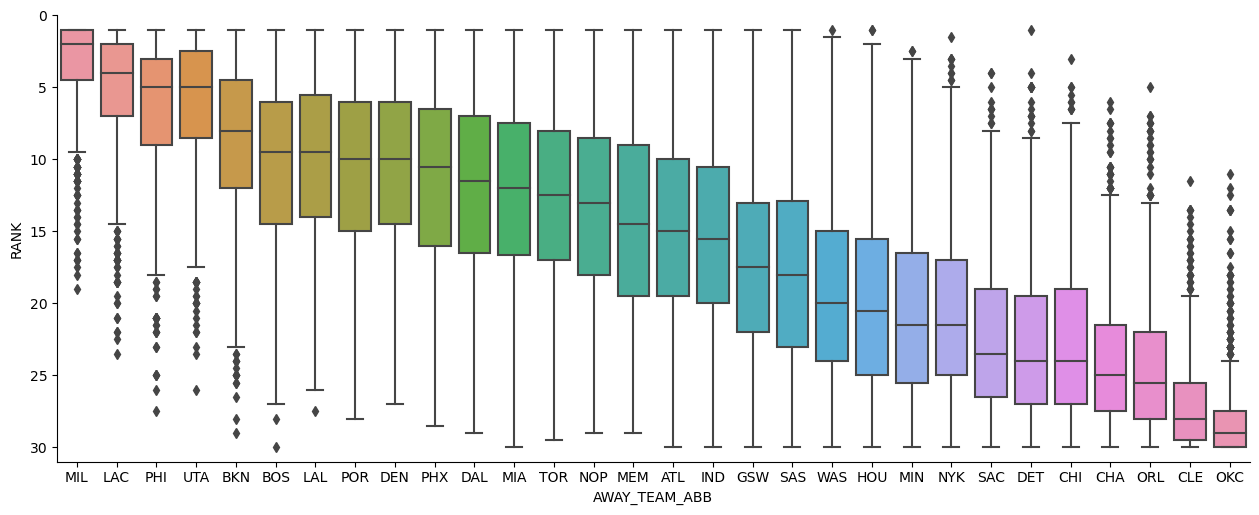

In [106]:
# plots performance whole league and conferences
team_conference = pd.read_csv("./data/data_assets/team_conference.csv", delimiter="\t")

performance = pd.merge(performance_tmp, team_conference, left_on="AWAY_TEAM_ABB", right_on="TEAM_ABBREVIATION", how='left')
performance['CONF_RANK'] = performance.groupby(['CONFERENCE', 'HISTORY'])['WINS'].rank(ascending=False)

# Find the order
my_order = performance.groupby('AWAY_TEAM_ABB')["RANK"].median().sort_values().index.values
chart = sns.catplot(data=performance, x='AWAY_TEAM_ABB', y="RANK", order=my_order, kind='box', aspect=2.5, sharex=False)

# edit axes
plt.ylim(0, 31)
plt.gca().invert_yaxis()

plt.show()

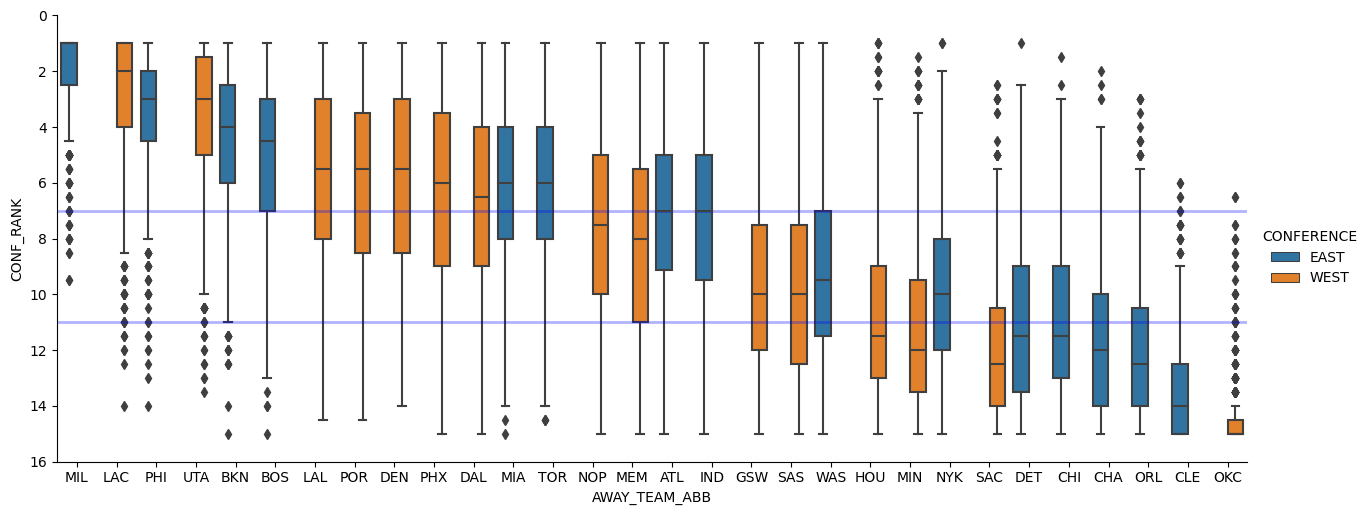

In [107]:
# Find the order
my_order = performance.groupby('AWAY_TEAM_ABB')["RANK"].median().sort_values().index
chart = sns.catplot(data=performance, x='AWAY_TEAM_ABB', y='CONF_RANK', hue='CONFERENCE', order=my_order, kind='box', aspect=2.5, sharex=False)

# edit axes
plt.ylim(0, 16)
plt.gca().invert_yaxis()

# play-in
chart.axes[0][0].axhline(y = 7, color='blue', linewidth=2, alpha=.3)
#chart.axes[1][0].axhline(y = 7, color='blue', linewidth=2, alpha=.3)

chart.axes[0][0].axhline(y = 11, color='blue', linewidth=2, alpha=.3)
#chart.axes[1][0].axhline(y = 11, color='blue', linewidth=2, alpha=.3)

plt.show()

In [108]:
def create_scoreboard(df_int_test, prediction, prediction_trade):
    """ creates wins and ranks teams
    """
    
    # insert prediction of PM
    df_int_test['Prediction_PM'] = prediction
    df_int_test['Prediction_Trade_PM'] = prediction_trade

    # count out wins from home and away
    df_int_test['WIN_HOME'] = np.where(df_int_test['PLUS_MINUS'] > 0, 1, 0)
    df_int_test['WIN_AWAY'] = np.where(df_int_test['PLUS_MINUS'] > 0, 0, 1)

    df_int_test['WIN_HOME_pred'] = np.where(df_int_test['Prediction_PM'] > 0, 1, 0)
    df_int_test['WIN_AWAY_pred'] = np.where(df_int_test['Prediction_PM'] > 0, 0, 1)

    df_int_test['WIN_HOME_trade'] = np.where(df_int_test['Prediction_Trade_PM'] > 0, 1, 0)
    df_int_test['WIN_AWAY_trade'] = np.where(df_int_test['Prediction_Trade_PM'] > 0, 0, 1)
    
    # season performance from home and away perspective
    season_performance_home = df_int_test.groupby(['SEASON_ID', 'HOME_TEAM_ABB'])[['WIN_HOME', 'WIN_HOME_pred', 'WIN_HOME_trade']].sum()
    season_performance_away = df_int_test.groupby(['SEASON_ID', 'AWAY_TEAM_ABB'])[['WIN_AWAY', 'WIN_AWAY_pred', 'WIN_AWAY_trade']].sum()
    season_performance_home.reset_index(inplace=True)
    season_performance_away.reset_index(inplace=True)
    
    # merge together based on teams
    season_performance_tmp = pd.merge(season_performance_home, season_performance_away, left_on=['SEASON_ID', 'HOME_TEAM_ABB'], right_on=['SEASON_ID', 'AWAY_TEAM_ABB'])

    # add up home and away for the total
    season_performance_tmp['WIN'] = season_performance_tmp['WIN_HOME'] + season_performance_tmp['WIN_AWAY']
    season_performance_tmp['WIN_pred'] = season_performance_tmp['WIN_HOME_pred'] + season_performance_tmp['WIN_AWAY_pred']
    season_performance_tmp['WIN_trade'] = season_performance_tmp['WIN_HOME_trade'] + season_performance_tmp['WIN_AWAY_trade']
    season_performance_tmp['TEAM_ABBREVIATION'] = season_performance_tmp['HOME_TEAM_ABB']
    
    # compute the predicted change due to trade
    season_performance_tmp['TRADE_CHANGE'] = season_performance_tmp['WIN_trade'] - season_performance_tmp['WIN_pred']
    
    # cosmetics
    season_performance = season_performance_tmp.drop(['HOME_TEAM_ABB', 'AWAY_TEAM_ABB', 'WIN_HOME', 'WIN_HOME_pred', 'WIN_HOME_trade', 'WIN_AWAY', 'WIN_AWAY_pred', 'WIN_AWAY_trade'], axis=1)
    
    # rankings
    season_performance['RANK'] = season_performance['WIN'].astype(int).rank(ascending=False)
    season_performance['RANK_pred'] = season_performance['WIN_pred'].astype(int).rank(ascending=False)
    season_performance['RANK_trade'] = season_performance['WIN_trade'].astype(int).rank(ascending=False)

    # order after rank
    season_performance = season_performance.sort_values(['SEASON_ID', 'RANK_pred'], ascending=True)
    
    return season_performance

In [109]:
import warnings
warnings.filterwarnings("ignore")

# simulate a season
one_season = simulate_one_season(mean_predicted=mean_plus_minus_pred, sigma_predicted=sigma_plus_minus_pred, n_sim=10000, all_games=False)

# create and show its scoreboard
scoreboard = create_scoreboard(df_int_test, mean_plus_minus_pred, mean_plus_minus_trade)
scoreboard

,SEASON_ID,WIN,WIN_pred,WIN_trade,TEAM_ABBREVIATION,TRADE_CHANGE,RANK,RANK_pred,RANK_trade
16,22021.0,46,64,64,MIL,0,7.0,1.0,1.0
12,22021.0,47,58,60,LAC,2,5.5,2.5,2.0
28,22021.0,52,58,57,UTA,-1,1.0,2.5,3.0
22,22021.0,49,56,56,PHI,0,3.0,4.0,4.0
1,22021.0,48,53,52,BKN,-1,4.0,5.0,5.0
2,22021.0,36,49,49,BOS,0,16.0,6.0,6.0
13,22021.0,42,48,44,LAL,-4,9.0,7.5,12.0
24,22021.0,42,48,48,POR,0,9.0,7.5,7.0
7,22021.0,47,47,47,DEN,0,5.5,9.0,8.0
6,22021.0,42,46,46,DAL,0,9.0,10.0,9.0


In [27]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge

# estimate ridge
ridge = Ridge(alpha=1e-3)
ridge.fit(X_train, y_train)

# estimate OLS
ols = LinearRegression()
ols.fit(X_train, y_train)

# estiamte RF
rf = RandomForestRegressor(max_depth=9, random_state=0, n_estimators=200)
rf.fit(X_train, y_train)

# test set scores
pred_rf = rf.predict(X_test)
pred_ols = ols.predict(X_test)
pred_ridge = ridge.predict(X_test)

trade_ols = ols.predict(X_trade)

ols.score(X_test, y_test), ridge.score(X_test, y_test), rf.score(X_test, y_test)

(0.0024769853107921014, 0.00247698915542216, 0.0016862004868489766)

In [1282]:
prediction = rf.predict(X_test)
df_int_test['Prediction_PM'] = prediction

In [1283]:
prediction = rf.predict(X_trade)
df_int_test['Prediction_Trade_PM'] = prediction

In [1284]:
df_int_test['WIN_HOME'] = np.where(df_int_test['PLUS_MINUS'] > 0, 1, 0)
df_int_test['WIN_AWAY'] = np.where(df_int_test['PLUS_MINUS'] > 0, 0, 1)
df_int_test['WIN_HOME_pred'] = np.where(df_int_test['Prediction_PM'] > 0, 1, 0)
df_int_test['WIN_AWAY_pred'] = np.where(df_int_test['Prediction_PM'] > 0, 0, 1)
df_int_test['WIN_HOME_trade'] = np.where(df_int_test['Prediction_Trade_PM'] > 0, 1, 0)
df_int_test['WIN_AWAY_trade'] = np.where(df_int_test['Prediction_Trade_PM'] > 0, 0, 1)

In [1285]:
season_performance_home = df_int_test.groupby(['SEASON_ID', 'HOME_TEAM_ABB'])[['WIN_HOME', 'WIN_HOME_pred', 'WIN_HOME_trade']].sum()
season_performance_away = df_int_test.groupby(['SEASON_ID', 'AWAY_TEAM_ABB'])[['WIN_AWAY', 'WIN_AWAY_pred', 'WIN_AWAY_trade']].sum()
season_performance_home.reset_index(inplace=True)
season_performance_away.reset_index(inplace=True)

season_performance_tmp = pd.merge(season_performance_home, season_performance_away, left_on=['SEASON_ID', 'HOME_TEAM_ABB'], right_on=['SEASON_ID', 'AWAY_TEAM_ABB'])

In [1287]:
season_performance_tmp['WIN'] = season_performance_tmp['WIN_HOME'] + season_performance_tmp['WIN_AWAY']
season_performance_tmp['WIN_pred'] = season_performance_tmp['WIN_HOME_pred'] + season_performance_tmp['WIN_AWAY_pred']
season_performance_tmp['WIN_trade'] = season_performance_tmp['WIN_HOME_trade'] + season_performance_tmp['WIN_AWAY_trade']
season_performance_tmp['TEAM_ABBREVIATION'] = season_performance_tmp['HOME_TEAM_ABB']

season_performance_tmp['TRADE_CHANGE'] = season_performance_tmp['WIN_trade'] - season_performance_tmp['WIN_pred']

season_performance = season_performance_tmp.drop(['HOME_TEAM_ABB', 'AWAY_TEAM_ABB', 'WIN_HOME', 'WIN_HOME_pred', 'WIN_HOME_trade', 'WIN_AWAY', 'WIN_AWAY_pred', 'WIN_AWAY_trade'], axis=1)

season_performance['RANK'] = season_performance['WIN'].astype(int).rank(ascending=False)
season_performance['RANK_pred'] = season_performance['WIN_pred'].astype(int).rank(ascending=False)
season_performance['RANK_trade'] = season_performance['WIN_trade'].astype(int).rank(ascending=False)

season_performance = season_performance.sort_values(['SEASON_ID', 'RANK'], ascending=True)

In [1288]:
season_performance['TRADE_CHANGE'].sum()

0

Get Ids of home and away team and then do two seperate aggregatations, merge and add up

In [1289]:
season_performance

,SEASON_ID,WIN,WIN_pred,WIN_trade,TEAM_ABBREVIATION,TRADE_CHANGE,RANK,RANK_pred,RANK_trade
21,22021.0,48,34,34,PHX,0,1.0,4.0,4.0
26,22021.0,38,34,35,UTA,1,2.0,4.0,3.0
6,22021.0,36,32,32,DAL,0,3.0,6.5,5.5
17,22021.0,35,29,29,MIN,0,4.0,11.5,12.0
9,22021.0,34,31,30,GSW,-1,5.0,8.0,8.5
12,22021.0,33,34,39,LAC,5,6.5,4.0,1.0
14,22021.0,33,29,29,MEM,0,6.5,11.5,12.0
15,22021.0,32,30,30,MIA,0,8.0,9.5,8.5
7,22021.0,31,28,29,DEN,1,9.0,13.0,12.0
2,22021.0,30,37,37,BOS,0,10.0,2.0,2.0


Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [PLUS_MINUS_sigma, Intercept, BENCH_DEPTH_AWAY, BENCH_DEPTH_HOME, SIXTH_AWAY_1_2, SIXTH_HOME_1_2, CENTER_AWAY_1_2, FORWARD_AWAY_2_2, FORWARD_AWAY_1_2, GUARD_AWAY_2_2, GUARD_AWAY_1_2, CENTER_HOME_1_2, FORWARD_HOME_2_2, FORWARD_HOME_1_2, GUARD_HOME_2_2, GUARD_HOME_1_2, SIXTH_AWAY_1, SIXTH_HOME_1, CENTER_AWAY_1, FORWARD_AWAY_2, FORWARD_AWAY_1, GUARD_AWAY_2, GUARD_AWAY_1, CENTER_HOME_1, FORWARD_HOME_2, FORWARD_HOME_1, GUARD_HOME_2, GUARD_HOME_1]


Sampling 4 chains for 200 tune and 2_000 draw iterations (800 + 8_000 draws total) took 135 seconds.
The acceptance probability does not match the target. It is 0.9024400855572318, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8956279807079796, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8934030293694913, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9009118183222199, but should be close to 0.8. Try to increase the number of tuning steps.


100%|██████████| 1000/1000 [00:06<00:00, 151.56it/s]


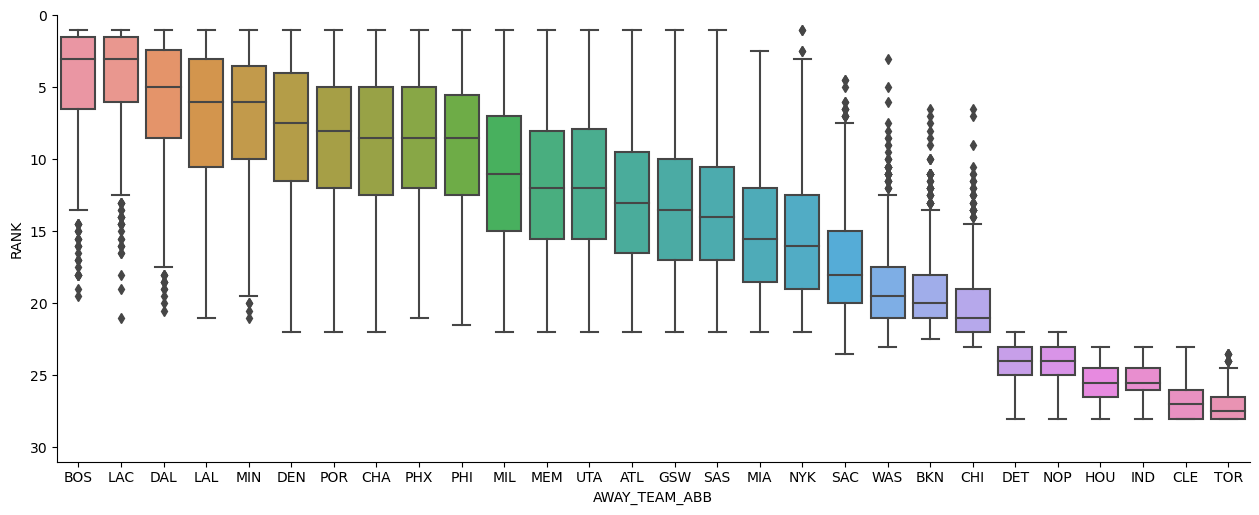

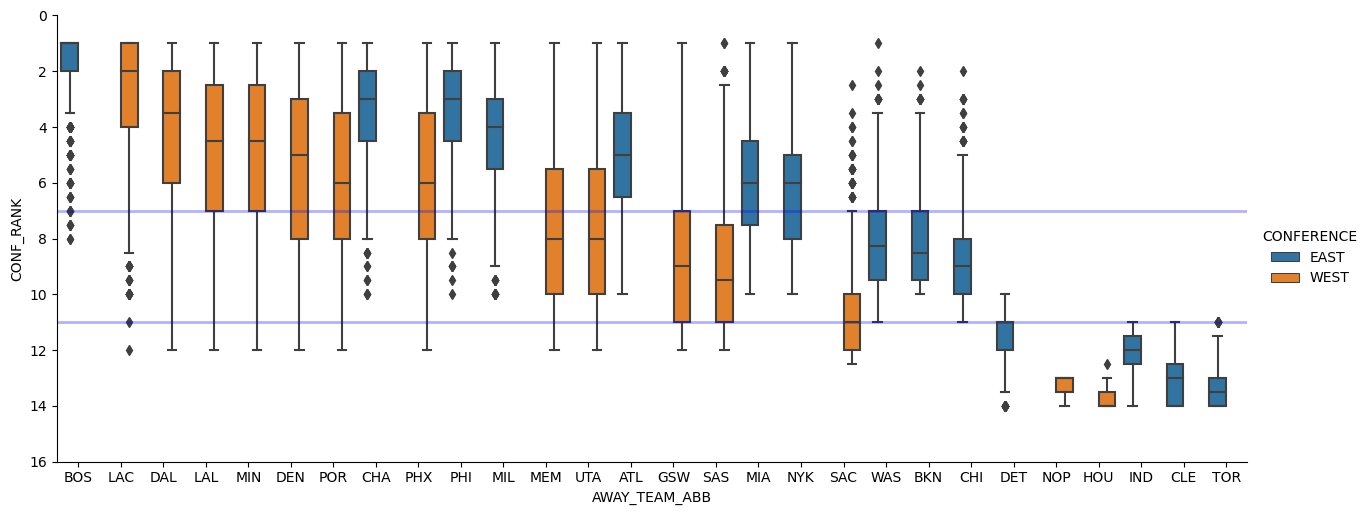

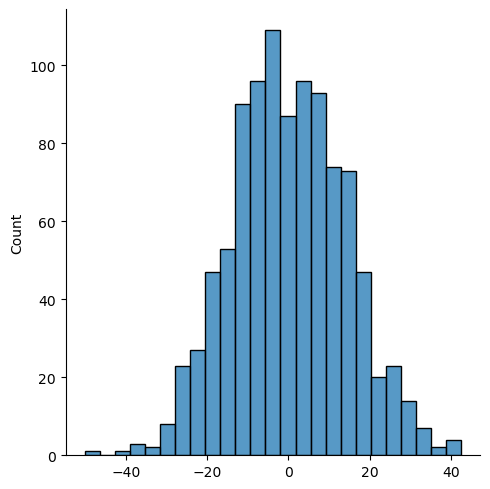

In [1332]:
sns.displot(season_sim[1, :])
plt.show()

# compute MAE on Plus Minus ratings to get a better idea!

,SEASON_ID,WIN,WIN_pred,WIN_trade,TEAM_ABBREVIATION,TRADE_CHANGE,RANK,RANK_pred,RANK_trade
2,22021.0,30,39,39,BOS,0,10.0,1.5,2.0
13,22021.0,25,39,31,LAL,-8,15.5,1.5,8.5
12,22021.0,33,37,41,LAC,4,6.5,3.0,1.0
21,22021.0,48,34,36,PHX,2,1.0,4.0,3.0
6,22021.0,36,33,32,DAL,-1,3.0,5.0,6.0
9,22021.0,34,32,32,GSW,0,5.0,7.0,6.0
16,22021.0,28,32,32,MIL,0,12.0,7.0,6.0
26,22021.0,38,32,34,UTA,2,2.0,7.0,4.0
20,22021.0,29,31,31,PHI,0,11.0,9.0,8.5
15,22021.0,32,30,30,MIA,0,8.0,10.0,10.0


In [1336]:
scoreboard = pd.merge(scoreboard, team_conference)

west = scoreboard[scoreboard['CONFERENCE'] == 'WEST']
east = scoreboard[scoreboard['CONFERENCE'] == 'EAST']

west['RANK_CONF'] = west['RANK'].rank(ascending=True)
east['RANK_CONF'] = east['RANK'].rank(ascending=True)

west = west.sort_values("RANK_CONF")
east = east.sort_values("RANK_CONF")

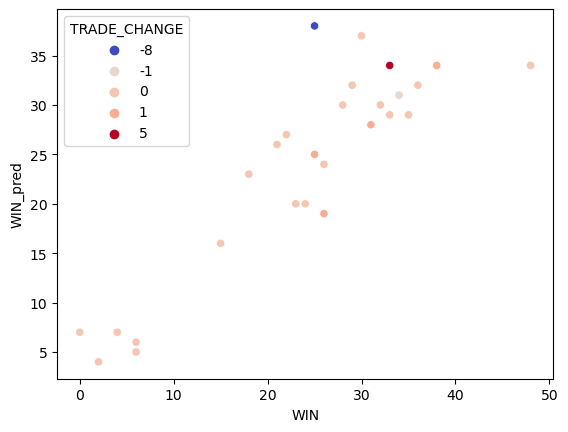

In [1337]:
sns.scatterplot(data=season_performance, x="WIN", y="WIN_pred", hue="TRADE_CHANGE", palette='coolwarm')
plt.show()